<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#任务介绍" data-toc-modified-id="任务介绍-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>任务介绍</a></span></li><li><span><a href="#创建图" data-toc-modified-id="创建图-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>创建图</a></span></li><li><span><a href="#图可视化" data-toc-modified-id="图可视化-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>图可视化</a></span></li><li><span><a href="#创建特征" data-toc-modified-id="创建特征-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>创建特征</a></span></li><li><span><a href="#定义GCN网络" data-toc-modified-id="定义GCN网络-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>定义GCN网络</a></span></li><li><span><a href="#模型训练" data-toc-modified-id="模型训练-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>模型训练</a></span></li></ul></div>

## 任务介绍

任务基于空手道俱乐部问题。空手道俱乐部里面有34个成员（图中的节点），节点成员之间在私下有联系（图上的边）。俱乐部后来分裂为以指导员（节点0）和俱乐部主席（节点33）为首的两个群体。任务是预测某个节点属于哪个群体。

![](https://data.dgl.ai/tutorial/img/karate-club.png)

## 创建图

In [121]:
import dgl
import numpy as np

In [122]:
def build_karate_club_graph():
    # All 78 edges are stored separately in two arrays. One for source nodes 
    # while the other for destination nodes.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGl, so construct a bi-directional graph for undirectional graph
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    return dgl.DGLGraph((u, v))

In [123]:
G = build_karate_club_graph()
print(f'++++ the graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges')

++++ the graph has 34 nodes and 156 edges


## 图可视化

In [124]:
import networkx as nx

In [125]:
%matplotlib inline

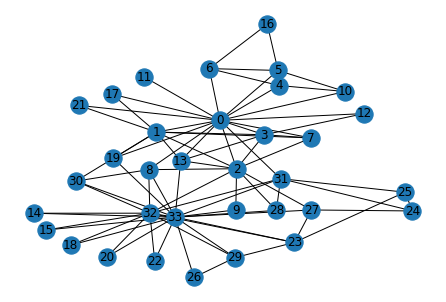

In [126]:
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True)

## 创建特征

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [128]:
num_nodes = 34
num_dim = 5

In [129]:
# assign learnable embeddings with 5 dimension for each nodes
embed = nn.Embedding(num_nodes, num_dim)
G.ndata['feat'] = embed.weight

In [130]:
print(G.ndata['feat'][0])

tensor([-3.4309,  0.7733, -0.1838,  0.8592, -0.4277], grad_fn=<SelectBackward>)


In [131]:
print(G.ndata['feat'][[12, 33]])

tensor([[ 2.0837,  0.6792,  0.2140,  0.3199,  1.2972],
        [ 3.3270, -0.3995, -1.0321, -0.0492, -0.0060]],
       grad_fn=<IndexBackward>)


In [132]:
print(G.ndata['feat'][0:2])

tensor([[-3.4309,  0.7733, -0.1838,  0.8592, -0.4277],
        [ 1.2188, -0.0399,  0.5272, -0.3506,  1.9132]],
       grad_fn=<SliceBackward>)


## 定义GCN网络

In [133]:
from dgl.nn.pytorch import GraphConv

In [134]:
class GCN(nn.Module):
    """A Graph Convolutional Network with two layers."""
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)
    
    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

In [135]:
net = GCN(num_dim, 5, 2)

## 模型训练

In [136]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [137]:
inputs = embed.weight
# only the instructor and president are labels
labeled_nodes = torch.tensor([0, 33])
labels = torch.tensor([0, 1])

In [138]:
import itertools

In [139]:
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []

for epoch in range(50):
    logits = net(G, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # only calculate negative log likelihood loss
    # labeled nodes.
    loss = F.nll_loss(logp[labeled_nodes], labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'+++ Epoch {epoch:4} | Loss {loss.item()}')
    
    

+++ Epoch    0 | Loss 1.063137173652649
+++ Epoch    1 | Loss 1.0083354711532593
+++ Epoch    2 | Loss 0.9572786092758179
+++ Epoch    3 | Loss 0.909367561340332
+++ Epoch    4 | Loss 0.8640438318252563
+++ Epoch    5 | Loss 0.8217037916183472
+++ Epoch    6 | Loss 0.7815675139427185
+++ Epoch    7 | Loss 0.743506908416748
+++ Epoch    8 | Loss 0.7085390686988831
+++ Epoch    9 | Loss 0.6752258539199829
+++ Epoch   10 | Loss 0.6429434418678284
+++ Epoch   11 | Loss 0.6118452548980713
+++ Epoch   12 | Loss 0.5823137164115906
+++ Epoch   13 | Loss 0.5549648404121399
+++ Epoch   14 | Loss 0.5289831161499023
+++ Epoch   15 | Loss 0.5044649243354797
+++ Epoch   16 | Loss 0.48336994647979736
+++ Epoch   17 | Loss 0.46267738938331604
+++ Epoch   18 | Loss 0.44201532006263733
+++ Epoch   19 | Loss 0.42144227027893066
+++ Epoch   20 | Loss 0.40123045444488525
+++ Epoch   21 | Loss 0.38145628571510315
+++ Epoch   22 | Loss 0.3622351288795471
+++ Epoch   23 | Loss 0.3435814082622528
+++ Epoch   2